In [184]:
from scipy.stats import ttest_ind
import scipy.stats as stats
import numpy as np
from math import sqrt
from scipy import stats
from numpy import cov, linspace
from statistics import mean
from numpy.random import normal, exponential
import matplotlib.pyplot as plt
from random import random
%matplotlib inline
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime as dt

In [185]:
# 1.1.   Импортируйте данные в окружение *Jupyter Notebook*.
# 1.2.   Изучите все три таблицы и проверьте их на наличие пустых значений.

data = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Данные', parse_dates=['dtime_pay'])
clients = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Clients') #, parse_dates=['dtime_ad'])
region_dict = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Region_dict')

In [186]:
# 1.3.   Исключите из таблиц все строки, в которых есть нулловые значения.

data = data.dropna() # если не дропать dtime_pay, мы не потеряем всего 17 платежей. Незначительное количество, поэтому смело дропаем всю таблицу
#clients = clients.dropna()
# В таблице clients есть незаполненные значения только в колонке dtime_ad.
# Чтобы не терять платежи, пустые значения оставляю. Заменять пустые значения чем-либо нет смысла.

In [187]:
print (data)
print (data.info())
print (clients)
print (clients.info())
print (region_dict)
print (region_dict.info())

       id_order  id_client  amt_payment               dtime_pay
0        100238   194569.0       5373.0 2022-10-28 04:05:15.221
1        100242   191056.0       4151.0 2022-08-01 02:42:54.992
2        100249   200049.0       5688.0 2022-08-24 12:45:12.744
3        100258   206161.0       4330.0 2022-12-09 15:13:26.437
4        100267   190945.0       5488.0 2022-08-03 02:07:31.468
...         ...        ...          ...                     ...
37983    297572   195257.0       2191.0 2022-08-21 18:31:51.585
37985    297593   179230.0       5755.0 2022-09-05 03:29:07.726
37986    297595   192530.0       4448.0 2022-09-27 23:50:05.734
37987    297601   183888.0       1746.0 2022-10-13 14:23:03.073
37988    297607   182638.0       3604.0 2022-10-13 14:51:59.902

[35828 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35828 entries, 0 to 37988
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         


In [188]:
# 1.4. Исследуйте количество торговых точек в каждом городе - постройте группировку по количеству в каждом городе.

cnt_trading_point = region_dict.groupby(['city'])['id_trading_point'].count().sort_values(ascending = False)

In [189]:
cnt_trading_point = cnt_trading_point.reset_index() 
cnt_trading_point = cnt_trading_point.rename(columns={'id_trading_point': 'cnt_trading_point'})

In [190]:
print (cnt_trading_point)
print (cnt_trading_point.info())

                city  cnt_trading_point
0    Санкт-Петербург                 11
1             Москва                 11
2             Казань                  6
3        Новосибирск                  6
4         Красноярск                  5
5          Краснодар                  4
6             Самара                  4
7           Мурманск                  2
8               Сочи                  2
9            Саратов                  2
10  Великий Новгород                  1
11             Чехов                  1
12            Тюмень                  1
13          Тольятти                  1
14         Сахалинск                  1
15      Петрозаводск                  1
16    Ростов-на-Дону                  1
17    Ростов Великий                  1
18          Владимир                  1
19   Нижний Новгород                  1
20           Дмитров                  1
21         Волгоград                  1
22         Ярославль                  1
<class 'pandas.core.frame.DataFrame'>
Ra

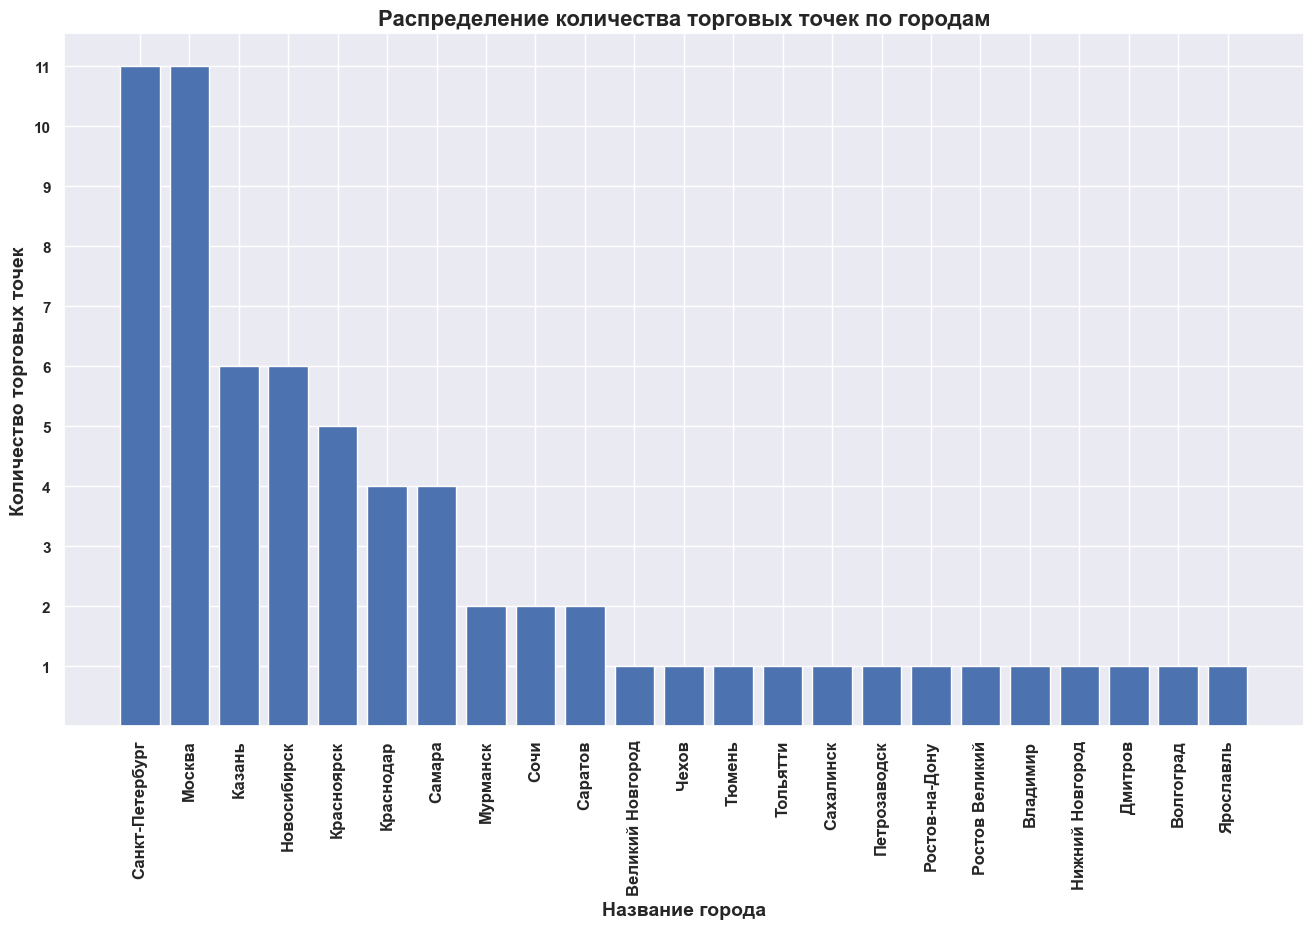

In [191]:
# визуализируйте с помощью гистограммы. 

plt.figure(figsize=(16, 9))
plt.bar (cnt_trading_point['city'], cnt_trading_point['cnt_trading_point'])
plt.xlabel (('Название города'), fontsize=14, fontweight='bold')
plt.xticks (rotation=90)
plt.xticks(fontsize=12, fontweight='bold')
plt.ylabel (('Количество торговых точек'), fontsize=14, fontweight='bold')
plt.yticks (range(1, 12), fontweight='bold')
plt.title (('Распределение количества торговых точек по городам'), fontsize=16, fontweight='bold')
plt.show()

In [192]:
# 2.1. У одного клиента может быть несколько платежей.
# Постройте агрегацию таблицы с платежами, где вычислите сумму платежей на каждого клиента.

sum_payment_per_client = data.groupby(['id_client'])['amt_payment'].sum().sort_values(ascending = False)

In [193]:
sum_payment_per_client = sum_payment_per_client.reset_index()
sum_payment_per_client = sum_payment_per_client.rename(columns={'amt_payment': 'sum_amt_payment'})

In [194]:
sum_payment_per_client[['id_client']] = sum_payment_per_client[['id_client']].astype( int )

In [195]:
# 2.2.   Соедините (по клиенту) сгруппированную таблицу с платежами с клиентской таблицей.
# Убедитесь, что в таблице остались все клиенты из клиентской таблицы.

payments_per_client= pd.merge(clients, sum_payment_per_client,
                              how='left',                      
         left_on='id_client', right_on='id_client')

In [196]:
# 2.3. Заполните нулями суммы покупок тех клиентов, которые их не совершали

payments_per_client['sum_amt_payment'] = payments_per_client['sum_amt_payment'].fillna(0)

In [197]:
# 2.4. С помощью словаря регионов подтяните к каждой торговой точке город, в котором она находится.

payments_per_client= pd.merge(payments_per_client, region_dict,
                              how='left',                      
         left_on='id_trading_point', right_on='id_trading_point')

In [198]:
# 2.5. Создайте поле флаг платежа, который принимает значения 0 или 1 в зависимости от того, заплатил клиент или нет

payments_per_client['flag_payment'] = np.where (payments_per_client ['sum_amt_payment']  > 0, 1, 0 )

In [199]:
payments_per_client

,id_client,dtime_ad,nflag_test,id_trading_point,sum_amt_payment,city,flag_payment
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,Красноярск,1
1,193942,NaT,0,13,4144.0,Нижний Новгород,1
2,226069,2022-07-11 16:28:38.511,1,54,0.0,Мурманск,0
3,183981,2022-06-16 12:23:59.289,1,991,6322.0,Казань,1
4,322530,2022-07-08 08:56:08.714,0,1015,0.0,Краснодар,0
...,...,...,...,...,...,...,...
55600,193038,2022-07-09 00:31:25.196,0,1015,5846.0,Краснодар,1
55601,244069,2022-08-08 00:12:31.319,1,991,0.0,Казань,0
55602,189084,2022-06-29 04:34:42.610,1,439,7146.0,Казань,1
55603,182758,2022-06-13 11:28:37.856,1,573,13720.0,Санкт-Петербург,1


In [200]:
# 3.1. Создайте функцию ***test_calc***, которая будет вычислять значение t-критерия (критерия Стьюдента) и *p_value* 
# для сравнения средних и с помощью функции *print* выводить сообщение о том, существует ли разница между 
# средними (на основании *p_value*).
# Аргументы функции:* *r1* (первая выборка), *r2* (вторая выборка), *alpha* (уровень значимости - имеет значение по умолчанию 5%)

In [201]:
def test_calc (r1, r2, alpha = 0.05):
    s, p = ttest_ind (r1, r2)
    print ('Т-тест: стат.критерий =' ,s )    
    print ('Т-тест: pvalue =' ,p )
    if p > alpha:
        print ('Т-тест: средние значения в выборках равны')
    else:
        print ('Т-тест: средние значения в выборках не равны')

In [202]:
# 3.2. Создайте функцию ***mann_whitney_func***, которая будет рассчитывать значение критерия Манна Уитни и p_value 
# для сравнения распределений и с помощью функции *print* выводить сообщение о том, существует ли разница между средними 
# (на основании *p_value*).
# Аргументы функции:* *r1* (первая выборка), *r2* (вторая выборка), *alpha* (уровень значимости - имеет значение по умолчанию 5%)

In [203]:
def mann_whitney_func (r1, r2, alpha = 0.05):
    s, p = stats.mannwhitneyu(r1, r2)
    print ('Тест М-У: стат. критерий =' ,s )
    print ('Тест М-У: pvalue =' ,p )
    if p > alpha:
        print ('Тест М-У: средние значения в выборках равны')
    else:
        print ('Тест М-У: средние значения в выборках не равны')
    #return s, p

In [204]:
# 4.1.  Создайте пустой список. Запустите цикл по всем торговым точкам и добавьте к этому списку все торговые точки,
# в которых не было заплачено ни одного рубля ни одним клиентом.

In [205]:
sum_payment_per_trading_point = payments_per_client.groupby(['id_trading_point'])['sum_amt_payment'].sum()

In [206]:
sum_payment_per_trading_point = sum_payment_per_trading_point.reset_index()

In [207]:
sum_payment_per_trading_point

,id_trading_point,sum_amt_payment
0,1,0.0
1,2,79513.0
2,4,0.0
3,7,0.0
4,11,2578570.0
...,...,...
61,3987,2571287.0
62,6543,2180031.0
63,8543,527842.0
64,9121,459518.0


In [208]:
zero_trading_point = []

for i, j in sum_payment_per_trading_point.iterrows():
    if j ['sum_amt_payment'] == 0:
        zero_trading_point.append (j ['id_trading_point'] )

print(zero_trading_point)

[1.0, 4.0, 7.0, 26.0]


In [209]:
# 4.2. Создайте еще один пустой список. Запустите цикл по всем торговым точкам и добавьте к этому списку все торговые точки,
# в которых пустует или контрольная, или тестовая группа.



In [210]:
zero_test_flag = []

for i, j in payments_per_client.iterrows():
    if j ['nflag_test'] == None:
        zero_test_flag.append (j ['id_trading_point'] )

print(zero_test_flag)

[]


In [211]:
# 5.1. Отбросьте все торговые точки, которые были вами обнаружены в пункте 4

payments_per_client_without_zero_trading_point = payments_per_client[~payments_per_client['id_trading_point'].isin(zero_trading_point)]
payments_per_client_without_zero_trading_point

,id_client,dtime_ad,nflag_test,id_trading_point,sum_amt_payment,city,flag_payment
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,Красноярск,1
1,193942,NaT,0,13,4144.0,Нижний Новгород,1
2,226069,2022-07-11 16:28:38.511,1,54,0.0,Мурманск,0
3,183981,2022-06-16 12:23:59.289,1,991,6322.0,Казань,1
4,322530,2022-07-08 08:56:08.714,0,1015,0.0,Краснодар,0
...,...,...,...,...,...,...,...
55600,193038,2022-07-09 00:31:25.196,0,1015,5846.0,Краснодар,1
55601,244069,2022-08-08 00:12:31.319,1,991,0.0,Казань,0
55602,189084,2022-06-29 04:34:42.610,1,439,7146.0,Казань,1
55603,182758,2022-06-13 11:28:37.856,1,573,13720.0,Санкт-Петербург,1


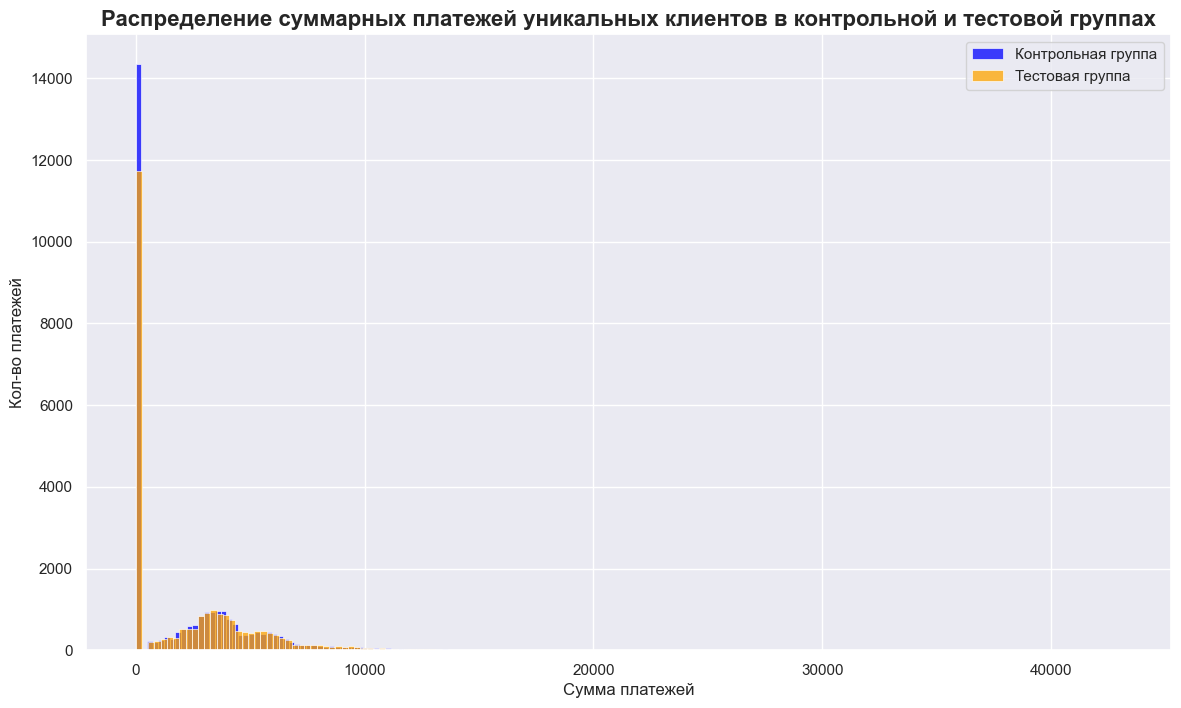

In [212]:
# 5.2. Изобразите гистограмму платежей, на которой различными цветами изображены группы “тест” и “контроль”.

sns.set(rc={'figure.figsize':(14, 8 )})
ax1 = sns.histplot(payments_per_client_without_zero_trading_point [ payments_per_client_without_zero_trading_point ['nflag_test']==0] ['sum_amt_payment'], color='blue')
ax2 = sns.histplot(payments_per_client_without_zero_trading_point [ payments_per_client_without_zero_trading_point ['nflag_test']==1] ['sum_amt_payment'], color='orange')
ax1.set  (xlabel='Сумма платежей', ylabel='Кол-во платежей')
plt.title (('Распределение суммарных платежей уникальных клиентов в контрольной и тестовой группах'), fontsize=16, fontweight='bold')
plt.legend( ['Контрольная группа' , 'Тестовая группа'] )
plt.show()

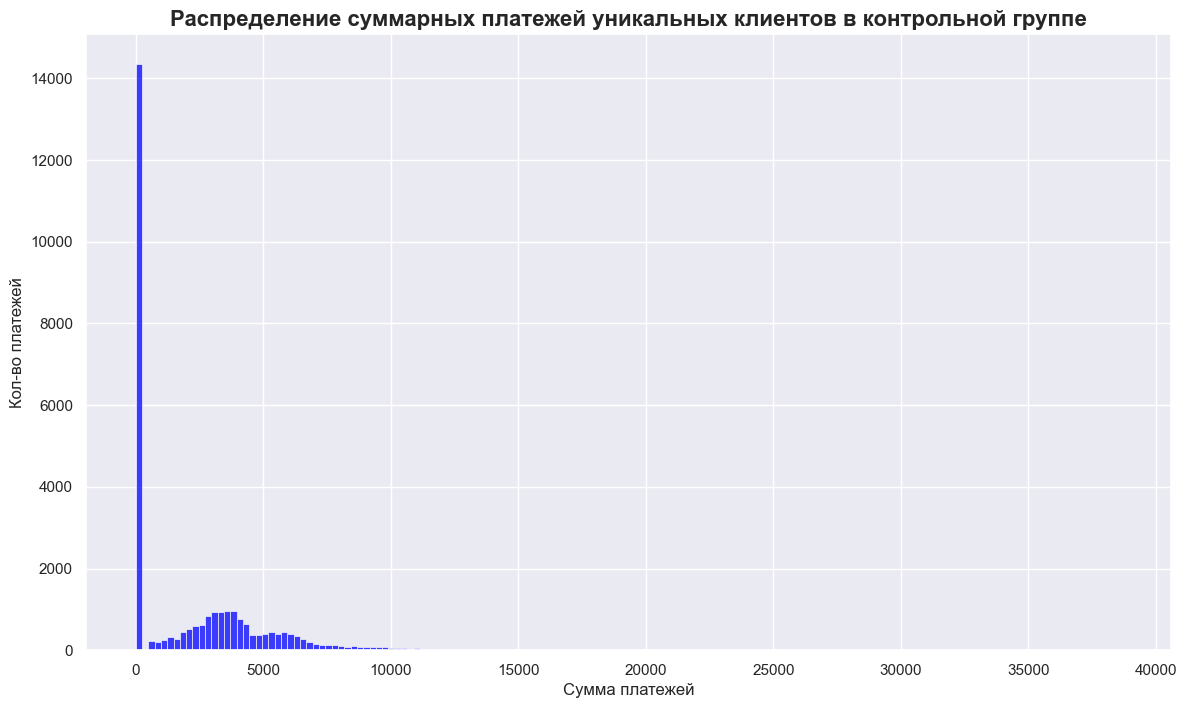

In [213]:
sns.set(rc={'figure.figsize':(14,8)})
ax1 = sns.histplot(payments_per_client_without_zero_trading_point [ payments_per_client_without_zero_trading_point ['nflag_test']==0] ['sum_amt_payment'], color='blue')
ax1.set  (xlabel='Сумма платежей', ylabel='Кол-во платежей')
plt.title (('Распределение суммарных платежей уникальных клиентов в контрольной группе'), fontsize=16, fontweight='bold')
plt.show()

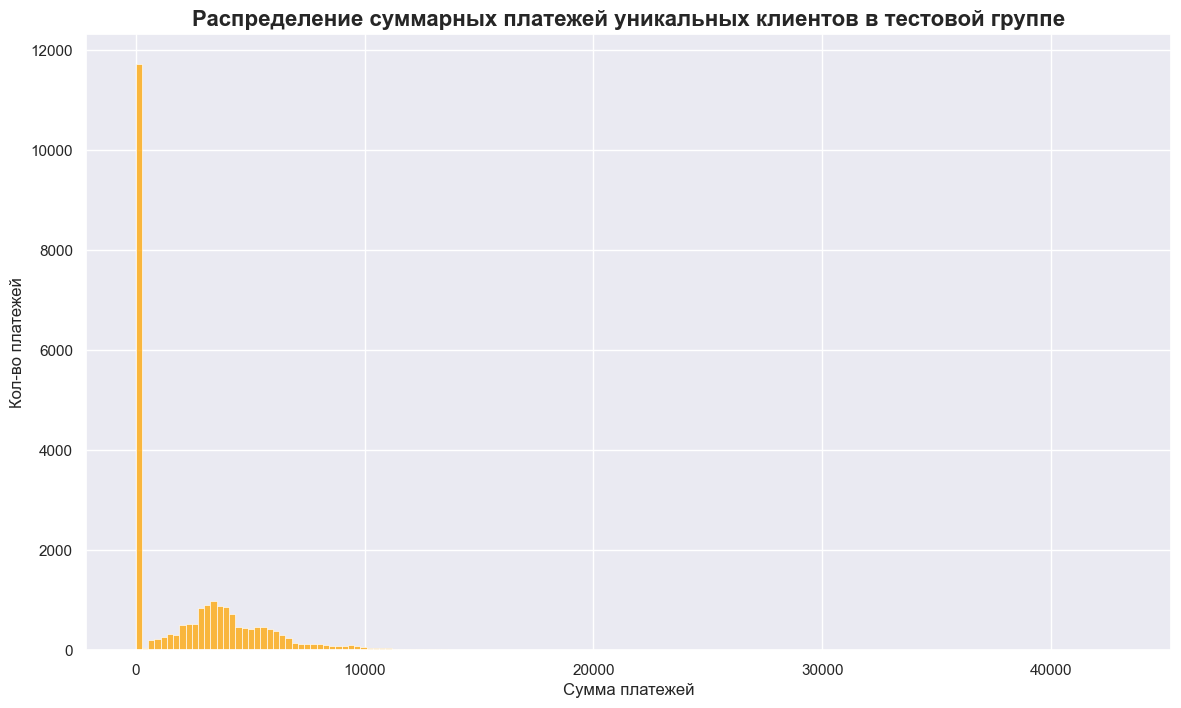

In [214]:
sns.set(rc={'figure.figsize':(14,8)})
ax2 = sns.histplot(payments_per_client_without_zero_trading_point [ payments_per_client_without_zero_trading_point ['nflag_test']==1] ['sum_amt_payment'], color='orange')
ax2.set  (xlabel='Сумма платежей', ylabel='Кол-во платежей')
plt.title (('Распределение суммарных платежей уникальных клиентов в тестовой группе'), fontsize=16, fontweight='bold')
plt.show()

In [215]:
# 5.3. Примените функцию test_calc и сделайте вывод (сравниваем средние платежи)

r1 = payments_per_client_without_zero_trading_point[ payments_per_client_without_zero_trading_point ['nflag_test']==0 ] ['sum_amt_payment']
r2 = payments_per_client_without_zero_trading_point[ payments_per_client_without_zero_trading_point ['nflag_test']==1 ] ['sum_amt_payment']

In [216]:
test_calc (r1, r2, alpha = 0.05)

Т-тест: стат.критерий = -6.890400488288935
Т-тест: pvalue = 5.6235533648548836e-12
Т-тест: средние значения в выборках не равны


In [217]:
# 5.4. Примените функцию test_calc и сделайте вывод (сравниваем конверсию в платеж, то есть r1 и r2 - это ряды нулей и единиц,
# в зависимости от того, оплатил ли что-то клиент или нет).

r3 = payments_per_client_without_zero_trading_point[ payments_per_client_without_zero_trading_point ['nflag_test']==0 ] ['flag_payment']
r4 = payments_per_client_without_zero_trading_point[ payments_per_client_without_zero_trading_point ['nflag_test']==1 ] ['flag_payment']

In [218]:
test_calc (r3, r4, alpha = 0.05)

Т-тест: стат.критерий = -5.828323333731957
Т-тест: pvalue = 5.630023064069756e-09
Т-тест: средние значения в выборках не равны


In [219]:
# 5.5. Примените функцию mann_whitney_func и сделайте вывод.

mann_whitney_func (r1, r2, alpha = 0.05)

Тест М-У: стат. критерий = 360079654.0
Тест М-У: pvalue = 9.797324854692603e-12
Тест М-У: средние значения в выборках не равны


In [220]:
mann_whitney_func (r3, r4, alpha = 0.05)

Тест М-У: стат. критерий = 362636031.5
Тест М-У: pvalue = 5.657905823521255e-09
Тест М-У: средние значения в выборках не равны


In [221]:
# 6.1.1. Повторите аналитику из пункта 5 в отношении Москвы. Сделайте выводы.

In [222]:
r1_msc =payments_per_client_without_zero_trading_point [ ( (payments_per_client_without_zero_trading_point['city']=='Москва') & (payments_per_client_without_zero_trading_point['nflag_test']== 0 ) ) ] ['sum_amt_payment']
r2_msc = payments_per_client_without_zero_trading_point [ ( (payments_per_client_without_zero_trading_point['city']=='Москва') & (payments_per_client_without_zero_trading_point['nflag_test']== 1 ) ) ] ['sum_amt_payment']

In [223]:
test_calc (r1_msc, r2_msc, alpha = 0.05)

Т-тест: стат.критерий = -7.676511027843395
Т-тест: pvalue = 1.757549439555765e-14
Т-тест: средние значения в выборках не равны


In [224]:
mann_whitney_func (r1_msc, r2_msc, alpha = 0.05)

Тест М-У: стат. критерий = 17582441.5
Тест М-У: pvalue = 7.010591402203484e-16
Тест М-У: средние значения в выборках не равны


In [225]:
r3_msc =payments_per_client_without_zero_trading_point[(payments_per_client_without_zero_trading_point['city']=='Москва') & (payments_per_client_without_zero_trading_point['nflag_test']== 0 )]['flag_payment']
r4_msc = payments_per_client_without_zero_trading_point[(payments_per_client_without_zero_trading_point['city']=='Москва') & (payments_per_client_without_zero_trading_point['nflag_test']== 1 )]['flag_payment']

In [226]:
test_calc (r3_msc, r4_msc, alpha = 0.05)

Т-тест: стат.критерий = -6.190312288026295
Т-тест: pvalue = 6.194689260032594e-10
Т-тест: средние значения в выборках не равны


In [227]:
mann_whitney_func (r3_msc, r4_msc, alpha = 0.05)

Тест М-У: стат. критерий = 18028079.0
Тест М-У: pvalue = 6.370381156613038e-10
Тест М-У: средние значения в выборках не равны


In [228]:
# 6.2.1. Повторите аналитику из пункта 5 в отношении Санкт-Петербурга. Сделайте выводы.

In [229]:
r1_spb =payments_per_client_without_zero_trading_point[(payments_per_client_without_zero_trading_point['city']=='Санкт-Петербург') & (payments_per_client_without_zero_trading_point['nflag_test']== 0 )]['sum_amt_payment']
r2_spb = payments_per_client_without_zero_trading_point[(payments_per_client_without_zero_trading_point['city']=='Санкт-Петербург') & (payments_per_client_without_zero_trading_point['nflag_test']== 1 )]['sum_amt_payment']

In [230]:
test_calc (r1_spb, r2_spb, alpha = 0.05)

Т-тест: стат.критерий = -8.759635784179547
Т-тест: pvalue = 2.3198088937974163e-18
Т-тест: средние значения в выборках не равны


In [231]:
mann_whitney_func (r1_spb, r2_spb, alpha = 0.05)

Тест М-У: стат. критерий = 8809444.5
Тест М-У: pvalue = 2.0392184217953754e-20
Тест М-У: средние значения в выборках не равны


In [232]:
r3_spb =payments_per_client_without_zero_trading_point[(payments_per_client_without_zero_trading_point['city']=='Санкт-Петербург') & (payments_per_client_without_zero_trading_point['nflag_test']== 0 )]['flag_payment']
r4_spb = payments_per_client_without_zero_trading_point[(payments_per_client_without_zero_trading_point['city']=='Санкт-Петербург') & (payments_per_client_without_zero_trading_point['nflag_test']== 1 )]['flag_payment']

In [233]:
test_calc (r3_spb, r4_spb, alpha = 0.05)

Т-тест: стат.критерий = -9.352468686561785
Т-тест: pvalue = 1.065825659919673e-20
Т-тест: средние значения в выборках не равны


In [234]:
mann_whitney_func (r3_spb, r4_spb, alpha = 0.05)

Тест М-У: стат. критерий = 8881151.0
Тест М-У: pvalue = 1.3118606823466691e-20
Тест М-У: средние значения в выборках не равны


In [235]:
# 6.3.1. Запустите цикл по оставшимся городам. Проведите такой же анализ.

In [236]:
ppccwztp = payments_per_client_without_zero_trading_point

In [237]:
for i, j in ppccwztp.groupby('city'):
    print (i)
    test_calc (j [j ['nflag_test'] == 0]['sum_amt_payment'],
               j [j ['nflag_test'] == 1]['sum_amt_payment'],
               alpha = 0.05)
    mann_whitney_func (j [j ['nflag_test'] == 0]['sum_amt_payment'],
                       j [j ['nflag_test'] == 1]['sum_amt_payment'],
                       alpha = 0.05)
    print()

Великий Новгород
Т-тест: стат.критерий = -0.2205874092976028
Т-тест: pvalue = 0.8256102434792962
Т-тест: средние значения в выборках равны
Тест М-У: стат. критерий = 6732.0
Тест М-У: pvalue = 0.816213668713835
Тест М-У: средние значения в выборках равны

Владимир
Т-тест: стат.критерий = -2.5769554932923184
Т-тест: pvalue = 0.010095112170351712
Т-тест: средние значения в выборках не равны
Тест М-У: стат. критерий = 143847.0
Тест М-У: pvalue = 0.03166761411886426
Тест М-У: средние значения в выборках не равны

Волгоград
Т-тест: стат.критерий = 2.0892718943323443
Т-тест: pvalue = 0.03686899928098654
Т-тест: средние значения в выборках не равны
Тест М-У: стат. критерий = 245743.0
Тест М-У: pvalue = 0.03323940159324537
Тест М-У: средние значения в выборках не равны

Дмитров
Т-тест: стат.критерий = -0.3310524347645207
Т-тест: pvalue = 0.7410763125801646
Т-тест: средние значения в выборках равны
Тест М-У: стат. критерий = 2722.0
Тест М-У: pvalue = 0.7422551789442879
Тест М-У: средние значения

In [238]:
# 7. Создание таблицы df_res
# Поля таблицы должны быть следующими:
# city - город
# id_trading_point  - уникальный идентификатор торговой точки, к которой прикреплен данный пользователь
# count_test - кол-во наблюдений в тестовой группе
# count_control - кол-во наблюдений в контрольной группе
# count_all - суммарное кол-во наблюдений
# percent_count - процент кол-ва наблюдений данной ТТ от всех наблюдений
# avg_payment_test - средний платеж в тестовой группе
# avg_payment_control - средний платеж в контрольной группе
# diff - разница между средними платежами
# sigma_test - стандартное отклонение платежей в тестовой группе
# sigma_control - стандартное отклонение платежей в контрольной группе
# ttest - значение статистического критерия (критерий Стьюдента для сравнения средних платежей)
# pvalue_ttest - pvalue статистического критерия (критерий Стьюдента для сравнения средних платежей)

In [239]:
ppccwztp = payments_per_client_without_zero_trading_point

In [240]:
df = pd.DataFrame(columns=['city',
                           'id_trading_point',
                           'count_test',
                           'count_control',
                           'count_all',
                           'percent_count',
                           'avg_payment_test',
                           'avg_payment_control',
                           'diff',
                           'sigma_test',
                           'sigma_control',
                           'ttest',
                           'pvalue_ttest',
                           'label'
                           ])

In [249]:
for city, city_data in ppccwztp.groupby('city'):
    for trading_point, trading_point_data in city_data.groupby('id_trading_point'):
        count_test = trading_point_data ['nflag_test'].sum()
        count_control = trading_point_data ['nflag_test'].count() - count_test
        count_all = trading_point_data ['nflag_test'].count()
        percent_count = count_test / count_all
        avg_payment_test = trading_point_data [trading_point_data['nflag_test'] == 1]['sum_amt_payment'].mean()
        avg_payment_control = trading_point_data[trading_point_data['nflag_test'] == 0]['sum_amt_payment'].mean()
        diff = avg_payment_test - avg_payment_control
        sigma_test = trading_point_data[trading_point_data['nflag_test'] == 1]['sum_amt_payment'].std()
        sigma_control = trading_point_data[trading_point_data['nflag_test'] == 0]['sum_amt_payment'].std()

        ttest_result = stats.ttest_ind (trading_point_data [trading_point_data ['nflag_test'] == 0]['sum_amt_payment'],
                                       trading_point_data [trading_point_data ['nflag_test'] == 1]['sum_amt_payment'])
        ttest_statistic = ttest_result.statistic
        pvalue_ttest = ttest_result.pvalue
        label = ''
        if diff > 0 and pvalue_ttest < 0.05:
            label = 'положительный исход'
        elif diff < 0 and pvalue_ttest < 0.05:
            label = 'отрицательный исход'
        else:
            label = 'нейтральный исход'
        
        df = df.append({'city': city,
                        'id_trading_point': trading_point,
                        'count_test': count_test,
                        'count_control': count_control,
                        'count_all': count_all,
                        'percent_count': percent_count,
                        'avg_payment_test': avg_payment_test,
                        'avg_payment_control': avg_payment_control,
                        'diff': diff,
                        'sigma_test': sigma_test,
                        'sigma_control': sigma_control,
                        'ttest': ttest_statistic,
                        'pvalue_ttest': pvalue_ttest,
                        'label':label}, ignore_index=True)

C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarn

C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'city': city,
C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\3186961076.py:25: FutureWarn

In [242]:
df

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,label
0,Великий Новгород,23,124,107,231,0.536797,1384.629032,1315.981308,68.647724,2471.691776,2220.010713,-0.220587,8.256102e-01,нейтральный исход
1,Владимир,11,509,608,1117,0.455685,2547.220039,2108.610197,438.609842,3023.702164,2663.038392,-2.576955,1.009511e-02,положительный исход
2,Волгоград,66,657,703,1360,0.483088,2288.870624,2601.761024,-312.890400,2682.567610,2830.193773,2.089272,3.686900e-02,отрицательный исход
3,Дмитров,2,78,71,149,0.523490,579.333333,483.450704,95.882629,1860.762430,1654.923182,-0.331052,7.410763e-01,нейтральный исход
4,Казань,439,355,351,706,0.502833,2481.960563,2400.635328,81.325236,4040.441007,3722.117072,-0.278067,7.810423e-01,нейтральный исход
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Сочи,72,609,639,1248,0.487981,2371.433498,2523.375587,-151.942089,2906.824458,2795.917176,0.941234,3.467676e-01,нейтральный исход
58,Сочи,73,187,167,354,0.528249,2092.181818,2521.958084,-429.776266,2530.274648,2875.459633,1.495845,1.355901e-01,нейтральный исход
59,Тольятти,88,190,167,357,0.532213,2902.410526,2439.461078,462.949448,3074.648887,2689.343053,-1.504556,1.333273e-01,нейтральный исход
60,Тюмень,19,130,146,276,0.471014,2043.823077,1743.376712,300.446365,2442.266788,2891.333359,-0.926459,3.550228e-01,нейтральный исход


In [243]:
# Таблица с положительными исходоми

df1 = df.loc[ df [ 'label' ] == 'положительный исход' ]

In [244]:
# Таблица с отрицательными исходоми

df2 = df.loc[ df [ 'label' ] == 'отрицательный исход' ]

In [245]:
# Таблица с нейтральными исходоми

df3 = df.loc[ df [ 'label' ] == 'нейтральный исход' ]

In [246]:
writer = pd.ExcelWriter('Для калькулятора.xlsx')

df1.to_excel(writer, sheet_name='Положительный исход', index=False)
df2.to_excel(writer, sheet_name='Отрицательный исход', index=False)
df3.to_excel(writer, sheet_name='Нейтральный исход', index=False)

In [247]:
writer.save()

C:\Users\MDi\AppData\Local\Temp\ipykernel_11772\934276808.py:1: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [248]:
# если p_value меньше 0,05 - то средние в 2х выборках не равны. Гипотеза о равенстве средних не подтверждается
# p_value > 0,05 - РАВНЫ